# Introducting to machine learning

## A hands-on tutorial using `python` and `scikit-learn`

**Ingo Scholtes**  
*October 2017*  

Welcome to this tutorial on machine learning, which accompanies my ten minute introductory lecture. 

To simplify this tutorial as much as possible, and to allow you to play with the methods introduced in the lecture, we need to define a couple of imports and helper functions. They mainly relate to machine learning techniques in the software package `scikit-learn`, to the visualisation of data and models, as well as to the representation of graphs or networks used in our example for unsupervised learning. To be able to use these methods, please first evaluate the following python cell.

In [23]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

import igraph
from IPython.display import *

from sklearn.naive_bayes import GaussianNB
from sklearn import datasets


def plotDigitPanel(digits, color_frac):
    for index, image in enumerate(digits.images[indices]):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), index+1)
        plt.axis('off')
        if index < color_frac * n:        
            if digits.target[indices[index]] == 3:
                plt.imshow(image, cmap=plt.cm.Blues, interpolation='nearest')
            elif digits.target[indices[index]] == 6:
                plt.imshow(image, cmap=plt.cm.Reds, interpolation='nearest')
            elif digits.target[indices[index]] == 5:
                plt.imshow(image, cmap=plt.cm.YlOrBr, interpolation='nearest')
        else:
            plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

    plt.savefig('digits_color_' + str(color_frac).replace('.', '_') +'.pdf')
    plt.show()

def plotData(data, classes, color_frac=1.0):
    h = 0.02    
    alpha = 0.8
    s = 60  
    
    x_min, x_max = 2.7, 4.5
    y_min, y_max = 2.7, 4.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    colored = int(len(data)*color_frac)
    plt.scatter(data[:, 0][:colored], data[:, 1][:colored], c=classes[:colored], cmap = plt.cm.coolwarm, s=s, edgecolors='k')
    plt.scatter(data[:, 0][colored:], data[:, 1][colored:], s=s, edgecolors='k', c='black', marker='x')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.xticks(())
    #plt.yticks(())
    plt.savefig('Data_colored_' + str(color_frac).replace('.', '_') + '.pdf')
    plt.show()    


def plotModel(data, classes, clf, marker='o', label=''):
    h = 0.02
    alpha = 0.8
    s = 60
    
    x_min, x_max = 2.7, 4.5
    y_min, y_max = 2.7, 4.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap = plt.cm.coolwarm, alpha=alpha)
    if marker!='o':
        plt.scatter(data[:, 0], data[:, 1], marker = marker, c='black', s=s, edgecolors='k')
    else:
        plt.scatter(data[:, 0], data[:, 1], c=classes, marker = marker, cmap = plt.cm.coolwarm, s=s, edgecolors='k')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.xlabel('X')
    plt.ylabel('Y')
    #plt.xticks(())
    #plt.yticks(())
    plt.savefig('Model_' + label + '.pdf')
    plt.show()

def plotNetwork(g, visual_style={}):
    igraph.plot(g, "temp.png", **visual_style)
    display(Image(filename='temp.png'))    
    
def memberships_to_groups(membership, colors):
    groups = defaultdict(lambda:list())
    for i in range(len(membership)):
        groups[membership[i]].append(i)
    groups_cols = []
    for i in groups.keys():
        groups_cols.append( (groups[i], colors[i]) )
    return groups_cols


## 1. Data collection and dimensionality reduction

Now that we have everything that we have everything that we need, we can get started. Following the example in the lecture, we will address the problem of recognising digits on images. For this, we will apply different machine learning techniques, that illustrate both unsupervised and supervised learning.

Before we can start, we first need a data set. Luckily, the package `scikit-learn` comes with a set of images of hand-written digits that we can use. We can load it as follows:

In [3]:
digits = datasets.load_digits()

Let us see what we have here. The returned variable `digits` is actually an object that contains three arrays `data`, `images` and `target`. We can access the i-th elements of these arrays to access a 8x8 matrix representation of pixel values (`images`), a flattened array representation of pixels with 64 values (`data`), as well as the actual digit shown by the image (`target`).

Let us see how this for the 15-th element. This element shows a 5 (which we can barely spot when we look at the matrix representation of the image). 

In [15]:
print(digits.images[15])
print(digits.data[15])
print(digits.target[15])

[[  0.   5.  12.  13.  16.  16.   2.   0.]
 [  0.  11.  16.  15.   8.   4.   0.   0.]
 [  0.   8.  14.  11.   1.   0.   0.   0.]
 [  0.   8.  16.  16.  14.   0.   0.   0.]
 [  0.   1.   6.   6.  16.   0.   0.   0.]
 [  0.   0.   0.   5.  16.   3.   0.   0.]
 [  0.   1.   5.  15.  13.   0.   0.   0.]
 [  0.   4.  15.  16.   2.   0.   0.   0.]]
[  0.   5.  12.  13.  16.  16.   2.   0.   0.  11.  16.  15.   8.   4.   0.
   0.   0.   8.  14.  11.   1.   0.   0.   0.   0.   8.  16.  16.  14.   0.
   0.   0.   0.   1.   6.   6.  16.   0.   0.   0.   0.   0.   0.   5.  16.
   3.   0.   0.   0.   1.   5.  15.  13.   0.   0.   0.   0.   4.  15.  16.
   2.   0.   0.   0.]
5


It is easier to spot the actual digit shown, when plotting the pixel data as an actual image, using the plotting library matplotlib:

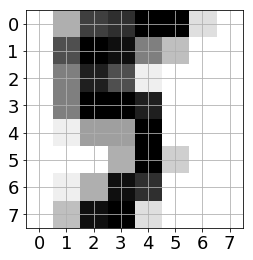

In [17]:
d = imageTo2D(digits.data[15])

plt.imshow(digits.images[15], cmap=plt.cm.gray_r, interpolation='none')
plt.xticks(range(8))
plt.yticks(range(8))
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('digit_' + str(i%10) + '.pdf')
plt.show()

Now that we have our data, let us continue with our machine learning problem. Since each image has 64 values, we actually deal with a high-dimensional problem. We thus want to reduce the dimensionality of our data before applying machine learning algorithms. There are various ways to do this in a clever way, but here - for simplicity - we use a very naive method. We simply calculate the center of mass of pixel values, i.e. we calculate a weighted average of all pixel coordinates. 

We can do this with the following method, which maps an (64-dimensional) image to a two-dimensional point.

In [18]:
def imageTo2D(data):
    m = np.reshape(data, (8,8))
    mass = 0
    for i in range(8):
        for j in range(8):
            mass += m[i,j] * np.array([i,j])
    return mass/np.sum(m)

Let us check whether this works. We can calculate the center of mass for the image of the 5 used before. 

In [19]:
print(imageTo2D(digits.data[15]))

[ 2.97878788  2.93333333]


Now let us visualise both the image and the center of mass in a plot:

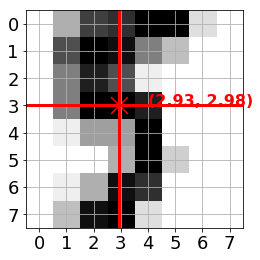

In [21]:
i = 15

font = {'color':  'red',
        'weight': 'bold',
        'size': 16,
        }

str_label = '(' + str(np.round(d[1], 2)) + ', ' + str(np.round(d[0], 2)) + ')'

plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='none')
plt.scatter(d[1], d[0], 280, 'red', 'x')
plt.xticks(range(8))
plt.yticks(range(8))
plt.axhline(y=d[0], color='red', linewidth=3)
plt.axvline(x=d[1], color='red', linewidth=3)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.text(4, 3, str_label, fontdict=font)
#plt.title('Digit: %i' % digits.target[i])
plt.show()

## 2. Supervised learning: Bayesian classifier

Now that we know how to embed our images into a two-dimensional feature space, let us consider the actual machine learning step. We will start with supervised learning, using a naive Bayesian classifier.

For this, we first need to define what are our data, and which are our training examples. Conveniently, the class (or digit) of each image can be found in the `target` field of the `digits` object above, i.e. the sample data set of `scikit-learn` provides us with labeled examples That means, we don't have to label our examples ourselves.

Let us use a total of 81 images, and use 75 % of those as training examples. For convenience, we further limit our problem to images corresponding to three different digits `3`, `5`, and `6`. The following lines of python code will randomly select 81 images of 3, 5 and 6 from the `digits` object, it will map these images to our two-dimensional feature space (using our function `imageto2D`) and it will store the features and known classes separately in two variables `data` and `classes`.

In [24]:
n = 81
training_frac = 0.75

indices = np.where( (digits.target==6) | (digits.target==3) | (digits.target==5))[0]
indices = np.random.choice(indices, n)
data = np.array([ imageTo2D(d) for d in digits.data[indices]])
classes = digits.target[indices]

To visualise the data (as well as the fraction of training examples used by our model) I have written a small convenience function, wich plots a 9x9 panel of images (as seen in the lecture). Note that this cell will take a few seconds to evaluate:

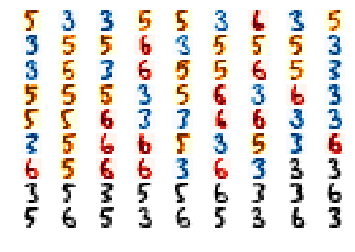

In [25]:
plotDigitPanel(digits, training_frac)

Let us now show how these images are embedded in our feature space. We will color the training examples with the correct colors, corresponding to the digits shown above.

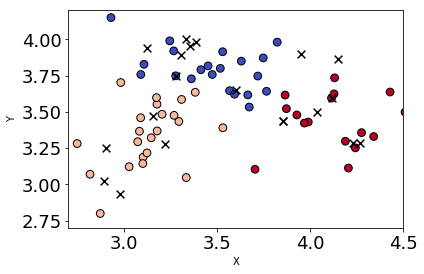

In [26]:
plotData(data, classes, color_frac=training_frac)

We are now ready to apply our naive Bayesian classifier. In the lecture, I have explained how this works mathematically, here we can simply use the implementation of a Bayesian classifier in `scikit-learn`. If you want to remind yourself again how this works, you can refer to the documentation here: http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes.

There are actually different versions of Bayesian classification implemented in scikit-learn. They differ in terms of the assumptions about the prior distribution of features `P(f)`, and for different types of features it is common to assume different distributions. In our case, we embed our images in a continuous space. For such scenarios, it is common to use a Guassian distribution. We can get the corresponding classifier as follows:

In [27]:
gnb = GaussianNB()

What is now left to do is to feed our training samples intot the classifier, and use the trained model predict the classes of images outside the training sample. Using standard python array slicing, this works as follows:

In [29]:
training_samples = int(training_frac*n)

trained_model = gnb.fit(data[:training_samples], classes[:training_samples])
prediction = trained_model.predict(data[training_samples:])

We can now evaluate the quality of our prediction, by counting for how many of our 25 % validation examples the prediction of the class was correct. This works as follows:

In [32]:
print("Number of mislabeled images out of a total %d points : %d" % (data[training_samples:].shape[0],(classes[training_samples:] != prediction).sum()))

Number of mislabeled images out of a total 21 points : 2


Great, using this simple model, we can correctly identify the digit shown on 19 of the 21 images! We see that our trained model actually captures the pattern in our feature space, which allows us to "read" digits on image data. 

## 2. Unsupervised learning: Graph Clustering

Now that we have seen how supervised learning works, let us turn our attention to an unsupervised technique. Our goal is to infer basic patterns in our data set, without having access to training data. In our case, we can learn from the data that there are three different digits in our data set, and we would like to tell which if the images actually contain the same digit (without actually knowing what these digits mean). 

As exmplained in the lecture, we would generally do this using a standard clustering algorithm like, e.g., k-means clustering (which is also implemented in `scikit-learn`). However, I intentionally take a different approach, turning the problem at hand into a graph clustering problem. For this, we consider each point in our feature space (e.g. each image or digit) as a node in a graph. We can then connect two nodes in the graph whenever their distance in the feature space is below a certain threshold. A first, simple distance measure that we can use is the Euclidean distance in the feature space. Alternatively, we could actually calculate the pixel distance based on the original image data, i.e. how different two corresponding pixels in two images are on average. 

Both distance measures are implemented in the following methods:

In [33]:
def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def pixel_dist(digit1, digit2):
    m1 = np.reshape(digit1, (8,8))
    #print(m1)    
    m2 = np.reshape(digit2, (8,8))
    #print(m2)
    pixeldiff = 0.0
    for i in range(8):
        for j in range(8):
            d = np.abs(m1[i,j] - m2[i,j])
            pixeldiff += d
    return pixeldiff/64

Let us now use this to turn our problem into a graph problem. For this, we use the python graph library igraph. We simply generate an empty (undirected) graph with 81 nodes, and then add links between nodes whenever the distance between them is below a given threshold (2.7 in our example). 

Apart from adding links, we also keep some information in the vertex attributes, in particular the class (i.e. digit) of the corresponding node, as well as the coordinate in the feature space (which we will use to visualise the graph). 

In [34]:
g = igraph.Graph(n = len(indices), directed=False)
                   
# 1. Turn points into a similarity matrix
for v in range(len(data)):
    g.vs[v]["name"] = str(v)
    g.vs[v]["class"] = digits.target[indices[v]]
    g.vs[v]["coord"] = (data[v][0], data[v][1])
    for w in range(len(data)):
        dist = pixel_dist(digits.images[indices[v]], digits.images[indices[w]])
        if dist < 2.7 and dist > 0:
            g.add_edge(v,w)         

Now that we have the graph, we want to visualise it. Luckily, this is comparably easy in igraph. We can do it with the following python code. Note that we generate a layout that places nodes at their corresponding position in the feature space (which we stored in the vertex properties `coord`. 

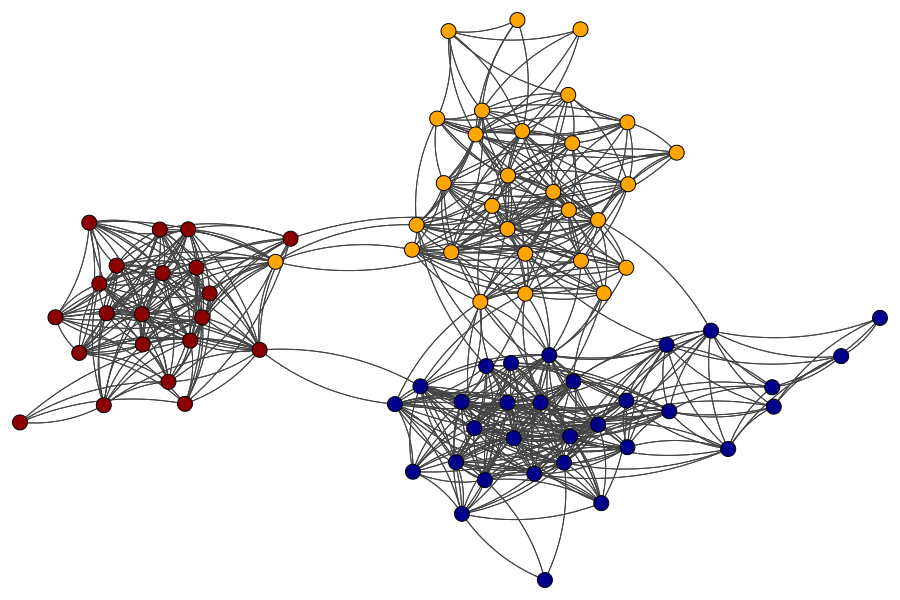

In [36]:
colors = {3:'darkblue', 5:'orange', 6:'darkred'}

visual_style = {}
visual_style["vertex_size"] = 15
visual_style["vertex_color"] = "lightgray"
visual_style["bbox"] = (900, 600)
visual_style["margin"] = 20
visual_style["edge_curved"] = 0.2

layout = igraph.Layout(coords=[c for c in g.vs["coord"]])
layout.fit_into((900, 600))
layout.mirror(1)

visual_style["vertex_color"] = [colors[v["class"]] for v in g.vs]
igraph.plot(g, "graph_colored.pdf", **visual_style)
plotNetwork(g, visual_style)

Great, the network topology nicely shows three clusters, or communities, which correspond to different digits (which are visualised as node colors). 

The next step is to apply an algorithm that is able to detect these natural clusters in our network. In the lecture, I have explained a probabilistic generatibve model (the so-called stochastic block model) which is, however, not implemented in igraph. We thus use a different clustering algorithm. It partitions nodes based on the leading eigenvector of a matrix representation of the network. We can call it as follows:

In [38]:
communities = g.as_undirected().community_leading_eigenvector(clusters=3)

Let us now visualise the detected clusters. For this, we use `bubbles` to group nodes in the same cluster, while the colors of nodes capture the actual digits in the data set.

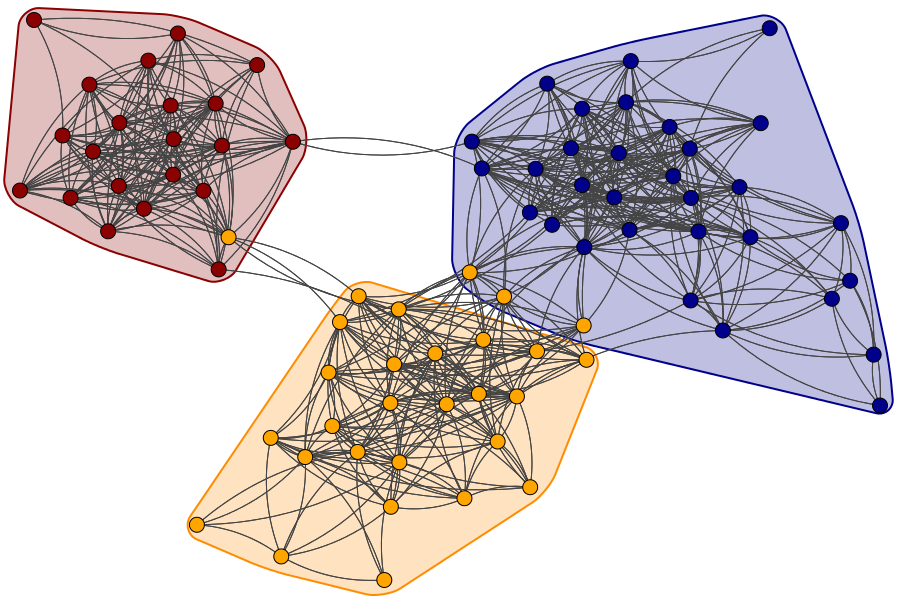

In [39]:
community_colors = ['darkorange', 'darkblue', 'darkred', 'yellow', 'orange', 'brown', 'green', 'black', 'cyan', 'magenta']
visual_style['mark_groups'] = memberships_to_groups(communities.membership, community_colors)

visual_style["vertex_color"] = [colors[v["class"]] for v in g.vs]
igraph.plot(g, "graph_colored_communities.pdf", **visual_style)
plotNetwork(g, visual_style)

Great, we see that we can use this simple graph clustering algorithm to group those images that correspond to the same image. There are, however, four images that are incorrectly assigned to clusters. This is due to the particularly naive embeddding that we have chosen in our example.

Feel free to use this notebook as a starting point for your own journey in the fascinating world of machine learning. Since this notebook is only for illustrative purposes, it will be very easy to improve on the results obtained above. 